# Classification with XGBoost and hyperparameter optimization

In [1]:
# import required libraries for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# open csv file
df = pd.read_csv('/kaggle/input/indian-liver-patient-records/indian_liver_patient.csv')
df.columns = df.columns.map(str.lower)                              # column names to lowercase
df.head()

,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [3]:
# check data types, it provides also details on null values, so next checking of null values may not be required
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         583 non-null    int64  
 1   gender                      583 non-null    object 
 2   total_bilirubin             583 non-null    float64
 3   direct_bilirubin            583 non-null    float64
 4   alkaline_phosphotase        583 non-null    int64  
 5   alamine_aminotransferase    583 non-null    int64  
 6   aspartate_aminotransferase  583 non-null    int64  
 7   total_protiens              583 non-null    float64
 8   albumin                     583 non-null    float64
 9   albumin_and_globulin_ratio  579 non-null    float64
 10  dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [4]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,583,NaN,NaN,NaN,44.7461,16.1898,4,33,45,58,90
gender,583,2,Male,441,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_bilirubin,583,NaN,NaN,NaN,3.2988,6.20952,0.4,0.8,1,2.6,75
direct_bilirubin,583,NaN,NaN,NaN,1.48611,2.8085,0.1,0.2,0.3,1.3,19.7
alkaline_phosphotase,583,NaN,NaN,NaN,290.576,242.938,63,175.5,208,298,2110
alamine_aminotransferase,583,NaN,NaN,NaN,80.7136,182.62,10,23,35,60.5,2000
aspartate_aminotransferase,583,NaN,NaN,NaN,109.911,288.919,10,25,42,87,4929
total_protiens,583,NaN,NaN,NaN,6.48319,1.08545,2.7,5.8,6.6,7.2,9.6
albumin,583,NaN,NaN,NaN,3.14185,0.795519,0.9,2.6,3.1,3.8,5.5
albumin_and_globulin_ratio,579,NaN,NaN,NaN,0.947064,0.319592,0.3,0.7,0.93,1.1,2.8


### What can we see from describe & info ?
- for gender we have 2 unique values - sounds reasonable
- there seems to be extremes for several fields (compare 75% with max) - we will have to fix it
- dataset, our target variable, has 2 values
- albumin_and_globulin_ratio have some missing values those must be handled

### Handle missing values
We are going to fix missing values on albumin_and_globulin_ratio field, easiest way is often best way, so just replace it with mean or median

In [5]:
# replacing missing values with mean
df.albumin_and_globulin_ratio.fillna(df.albumin_and_globulin_ratio.mean(), inplace=True)

In [6]:
# are there still any missing values?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         583 non-null    int64  
 1   gender                      583 non-null    object 
 2   total_bilirubin             583 non-null    float64
 3   direct_bilirubin            583 non-null    float64
 4   alkaline_phosphotase        583 non-null    int64  
 5   alamine_aminotransferase    583 non-null    int64  
 6   aspartate_aminotransferase  583 non-null    int64  
 7   total_protiens              583 non-null    float64
 8   albumin                     583 non-null    float64
 9   albumin_and_globulin_ratio  583 non-null    float64
 10  dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


## Let's start exploratory data analysis (EDA)
Most datascientist will tell you that EDA is most funny part of datascience work. You are exploring different relations between data and how they interact... so do it!

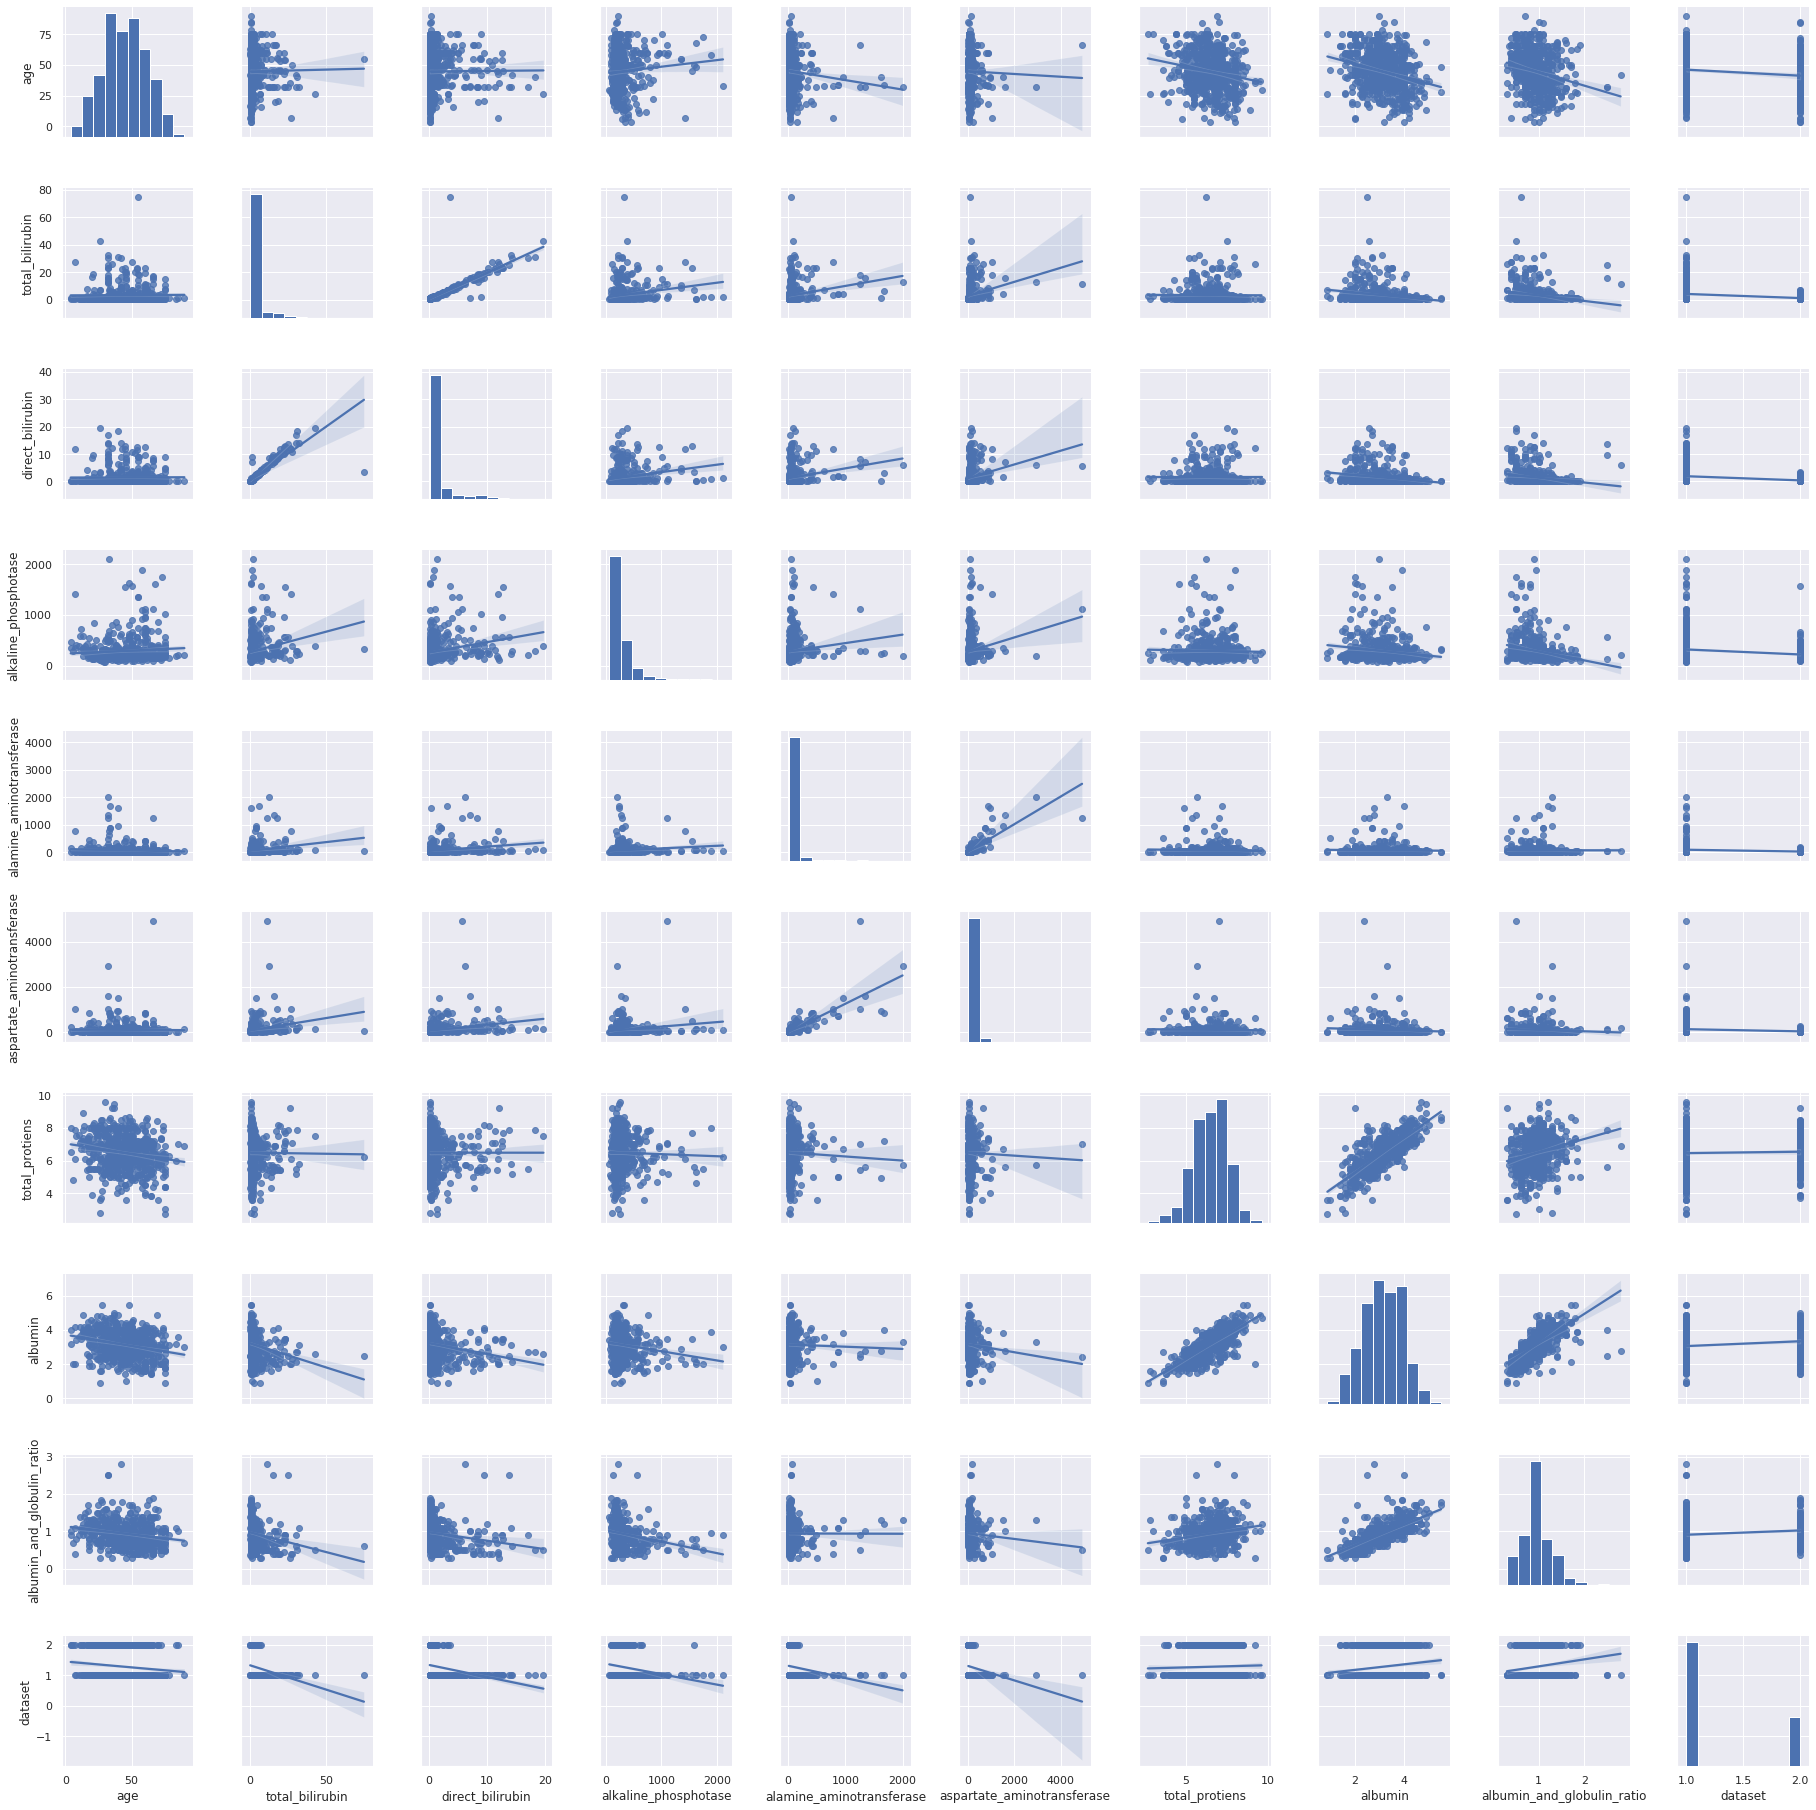

In [7]:
# correlation between variables
sns.set()
sns.pairplot(df, kind='reg')

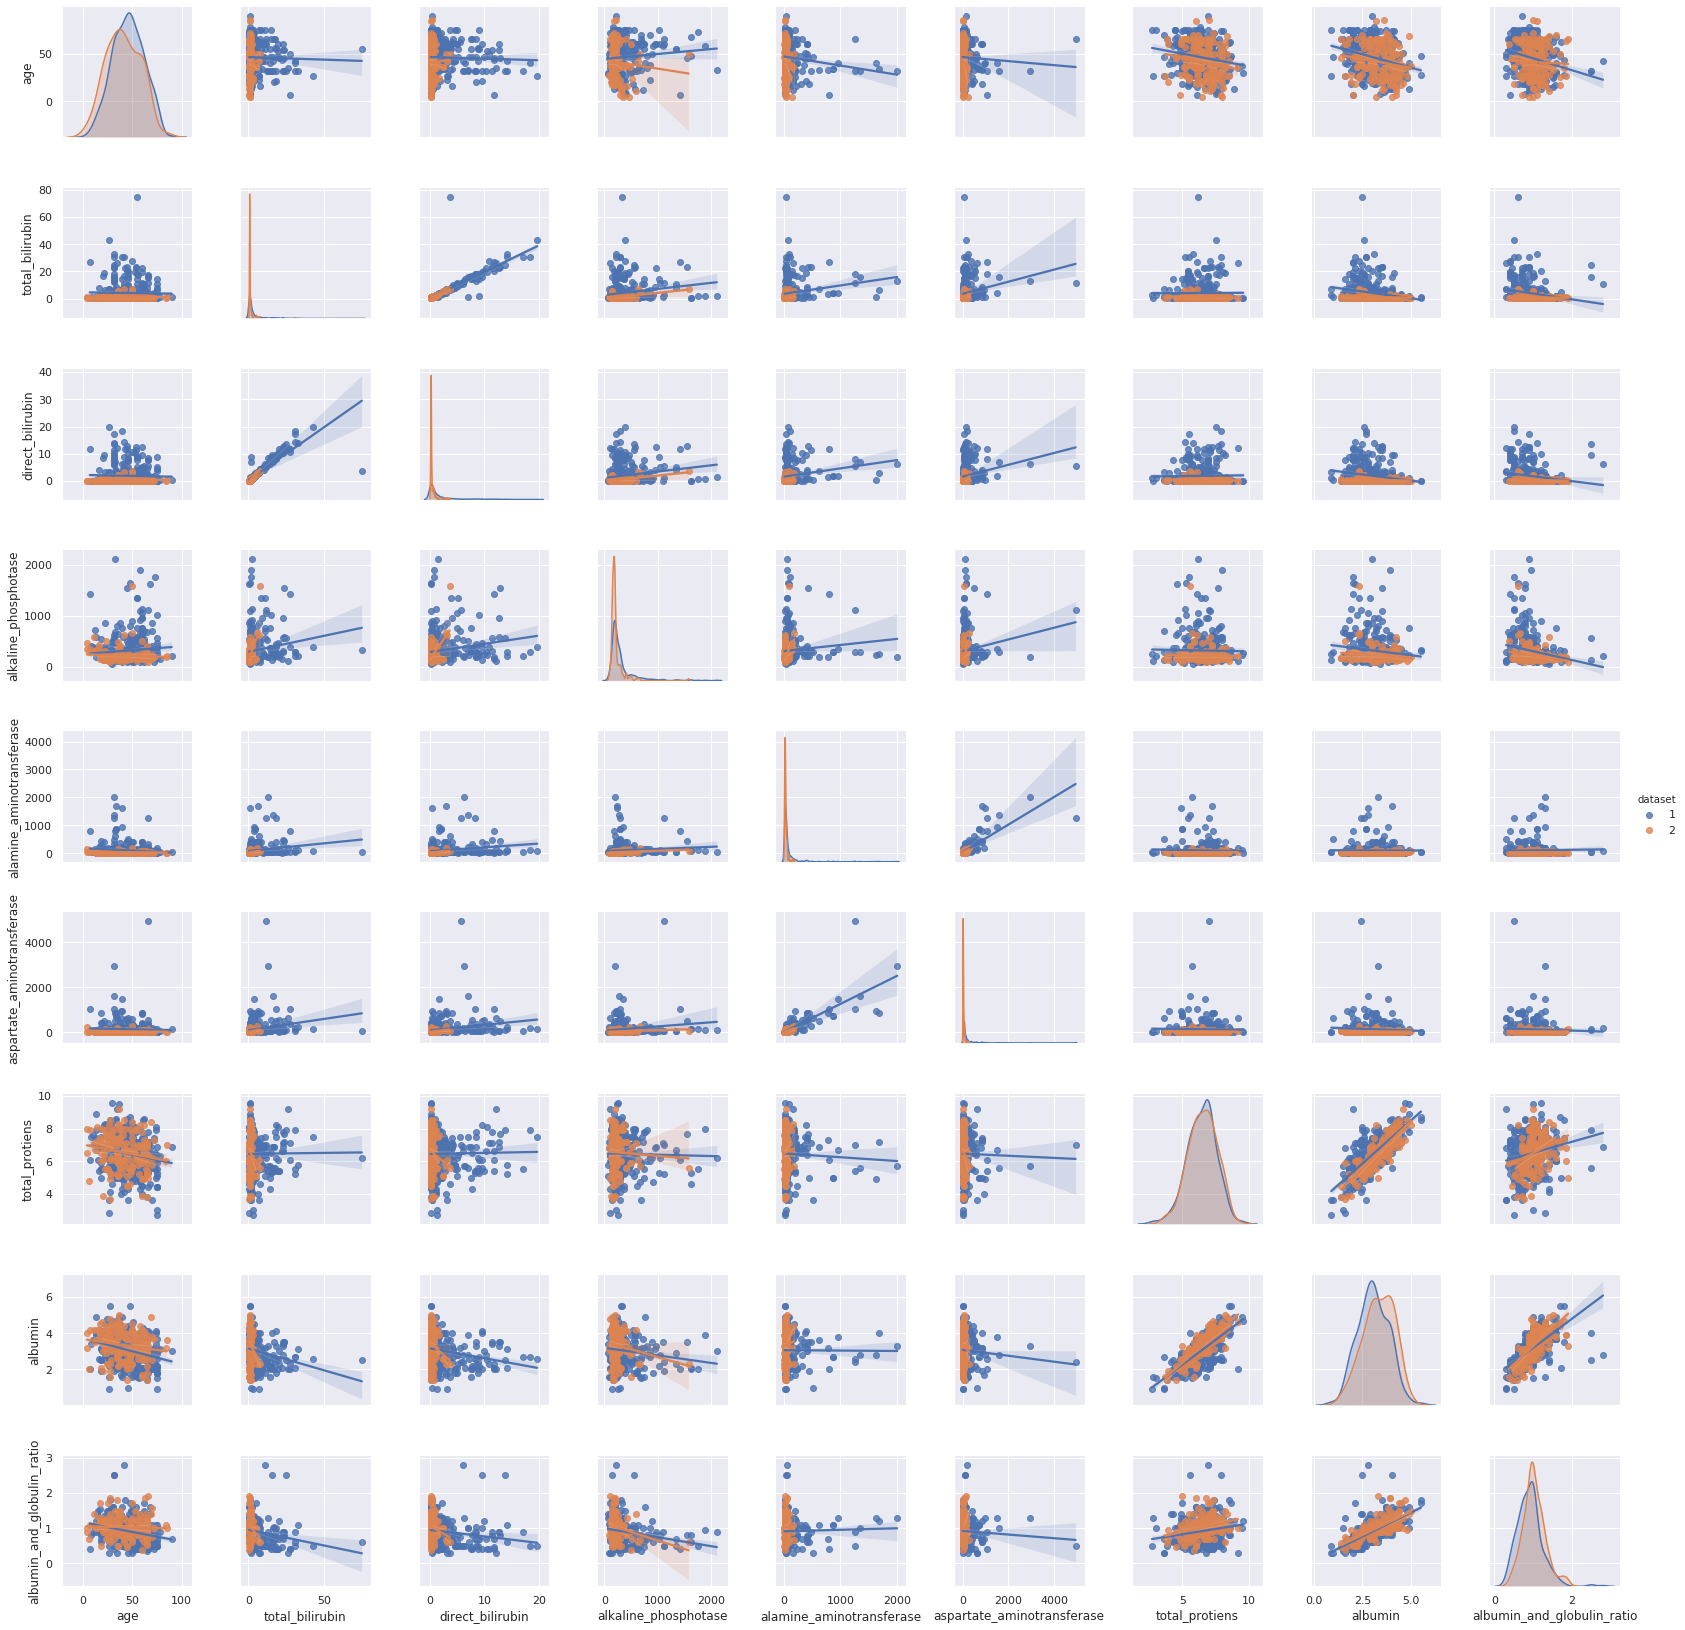

In [8]:
# correlation between variables
sns.set()
sns.pairplot(df, hue='dataset', kind='reg')

In [9]:
# correlation with dataset - target value
df.corr()['dataset']

age                          -0.137351
total_bilirubin              -0.220208
direct_bilirubin             -0.246046
alkaline_phosphotase         -0.184866
alamine_aminotransferase     -0.163416
aspartate_aminotransferase   -0.151934
total_protiens                0.035008
albumin                       0.161388
albumin_and_globulin_ratio    0.162319
dataset                       1.000000
Name: dataset, dtype: float64

In [10]:
# full correlation table
df.corr().style.background_gradient(cmap='viridis')

,age,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,dataset
age,1.000000,0.011763,0.007529,0.080425,-0.086883,-0.019910,-0.187461,-0.265924,-0.216089,-0.137351
total_bilirubin,0.011763,1.000000,0.874618,0.206669,0.214065,0.237831,-0.008099,-0.222250,-0.206159,-0.220208
direct_bilirubin,0.007529,0.874618,1.000000,0.234939,0.233894,0.257544,-0.000139,-0.228531,-0.200004,-0.246046
alkaline_phosphotase,0.080425,0.206669,0.234939,1.000000,0.125680,0.167196,-0.028514,-0.165453,-0.233960,-0.184866
alamine_aminotransferase,-0.086883,0.214065,0.233894,0.125680,1.000000,0.791966,-0.042518,-0.029742,-0.002374,-0.163416
aspartate_aminotransferase,-0.019910,0.237831,0.257544,0.167196,0.791966,1.000000,-0.025645,-0.085290,-0.070024,-0.151934
total_protiens,-0.187461,-0.008099,-0.000139,-0.028514,-0.042518,-0.025645,1.000000,0.784053,0.233904,0.035008
albumin,-0.265924,-0.222250,-0.228531,-0.165453,-0.029742,-0.085290,0.784053,1.000000,0.686322,0.161388
albumin_and_globulin_ratio,-0.216089,-0.206159,-0.200004,-0.233960,-0.002374,-0.070024,0.233904,0.686322,1.000000,0.162319
dataset,-0.137351,-0.220208,-0.246046,-0.184866,-0.163416,-0.151934,0.035008,0.161388,0.162319,1.000000


**Outcome?** I've seen in many datasets there is none. Data scientist just simply show correlation and skip any actions to be done... not in this case! 
We have strong correlation between some variables:
- direct_bilirubin & total_bilirubin
- aspartate_aminotransferase & alamine_aminotransferase
- total_protiens & albumin
- albumin_and_globulin_ratio & albumin

We will drop some of them as features should be independent

In [11]:
# this is simply my selection (from highly correlated features, you could also use different from pairs)
df.drop(['direct_bilirubin', 'aspartate_aminotransferase', 'total_protiens', 'albumin'], axis=1, inplace=True)

### Outliers & transformation
Now check data using boxplot and distplot to see what features are skewed, what is ratio of outliers, if log1p helps etc

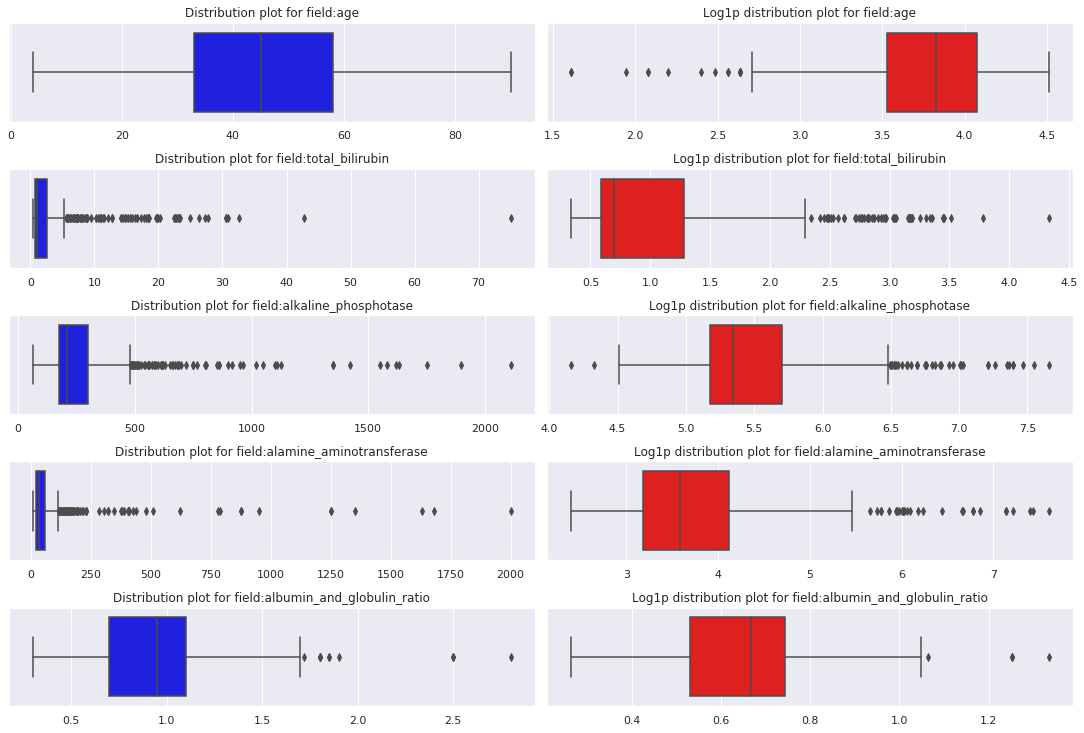

In [12]:
# outlier check
plt.figure(figsize=(15, 20))

for i, c in enumerate(df.drop('dataset', axis=1).select_dtypes(include='number').columns):
    plt.subplot(10,2,i*2+1)
    sns.boxplot(df[c], color='blue')
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

    
    plt.subplot(10,2,i*2+2)
    sns.boxplot(df[c].apply('log1p'), color='red')
    plt.title('Log1p distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

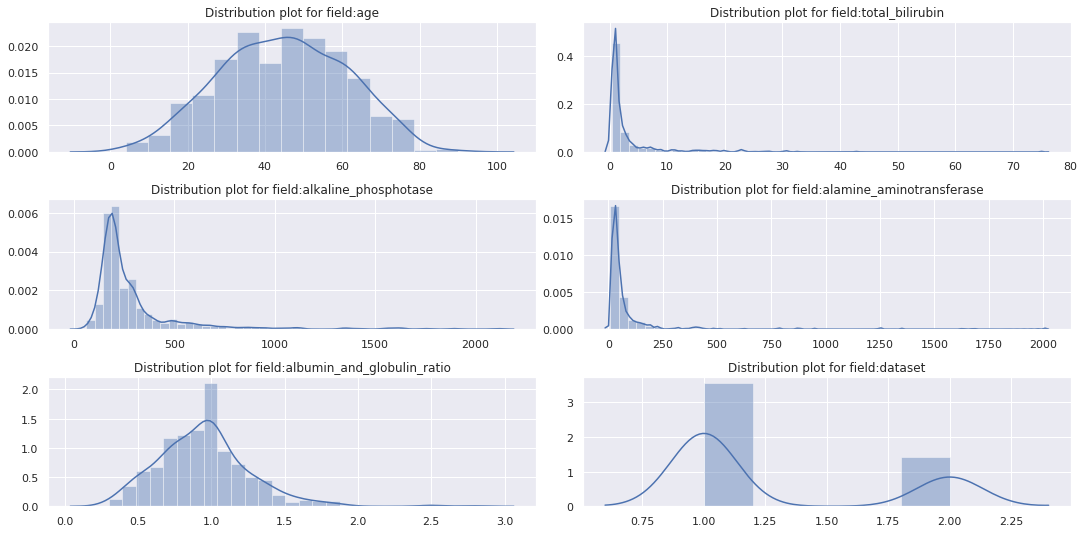

In [13]:
plt.figure(figsize=(15, 12))

for i, c in enumerate(df.select_dtypes(include='number').columns):
    plt.subplot(5,2,i+1)
    sns.distplot(df[c])
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


#### What can we get out of dist plot and box plot?
- dataset is slightly imbalanced
- slightly skewed features: albumin_and_globulin_ration
- strongly skewed features: total_bilirubin, direct_bilirubin, alkaline_phosphotase, alamine_aminotransferase, aspartate_aminotransferase

We will fix these values using log1p transformation and then scale variables using RobustScaler as this one is good for data with outliers. If you think this is not good procedure, let me know!

In [14]:
# save skewed features
skewed_cols = ['albumin_and_globulin_ratio','total_bilirubin', 'alkaline_phosphotase', 'alamine_aminotransferase']

In [15]:
# Apply log1p transformation on dataframe - just selected values
for c in skewed_cols:
    df[c] = df[c].apply('log1p')

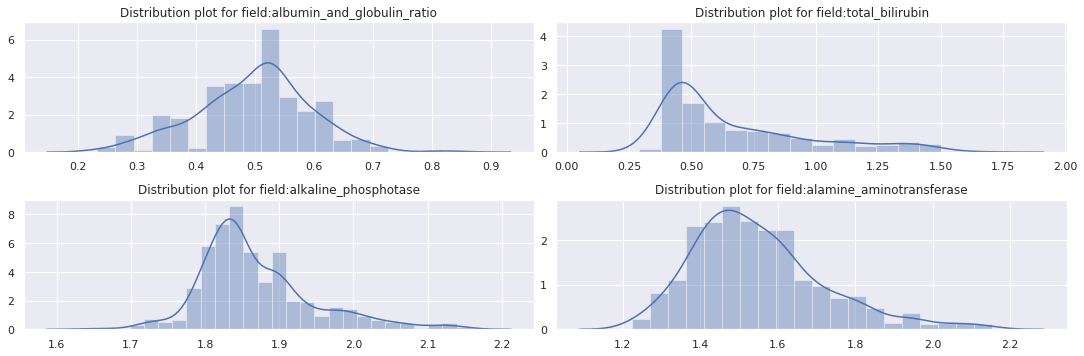

In [16]:
# Next check & fix strongly skewed features
# apply log1p transform
plt.figure(figsize=(15, 12))

for i, c in enumerate(skewed_cols):
    plt.subplot(5,2,i+1)
    sns.distplot(df[c].apply(np.log1p))
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

## Encode & Scale
I will use sklearn library to encode gender and scale numerical variables

In [17]:
from sklearn.preprocessing import LabelEncoder, RobustScaler

In [18]:
# gender contains string values Male, Female; these will be converted into 0, 1, as ML algorithms like just numerical values
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df.gender.head()

0    0
1    1
2    1
3    1
4    1
Name: gender, dtype: int64

In [19]:
rs = RobustScaler()
for c in df[['age', 'gender', 'total_bilirubin', 'alkaline_phosphotase', 'alamine_aminotransferase', 'albumin_and_globulin_ratio']].columns:
    df[c] = rs.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,age,gender,total_bilirubin,alkaline_phosphotase,alamine_aminotransferase,albumin_and_globulin_ratio,dataset
0,0.80,-1.0,-0.234465,-0.200886,-0.797391,-0.115796,1
1,0.68,0.0,2.572890,2.293084,0.627949,-0.532099,1
2,0.68,0.0,2.053111,1.620312,0.560449,-0.140769,1
3,0.52,0.0,0.000000,-0.252023,-0.930409,0.126945,1
4,1.08,0.0,1.292782,-0.121830,-0.267086,-1.560985,1


## Balance data
As our dataset is imbalanced, will use sklearn's sample to have same ratio of target variables (we could use also SMOTE from imblearn).
This may not be needed each time as some algorithms already have techniques for imbalanced datasets

In [20]:
from sklearn.utils import resample
df.dataset.value_counts()

1    416
2    167
Name: dataset, dtype: int64

In [21]:
# Split data on majority and minority.. minority is dataset == 2
minority = df[df.dataset==2]
majority = df[df.dataset==1]

print('Minority size:', minority.shape)
print('Majority size:', majority.shape)

Minority size: (167, 7)
Majority size: (416, 7)


In [22]:
# choosing upsample as even now we do not have too much data
minority_upsample = resample(minority, replace=True, n_samples=majority.shape[0])
print('Minority upsampled size:', minority_upsample.shape)

Minority upsampled size: (416, 7)


In [23]:
# merge majority with upsampled minority
df = pd.concat([minority_upsample, majority], axis=0)

## Split data for modeling
This is very needed in order to be able to compare performance of model on unseen data. I will choose test size to be 0.25. Dataset is also split to X (features) and y (target) variables.

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('dataset', axis=1), df['dataset'], test_size=0.25, random_state=123)

print('Train values shape:', X_train.shape)
print('Test values shape:', X_test.shape)
print('Train target shape:', y_train.shape)
print('Test target shape:', y_test.shape)

Train values shape: (624, 6)
Test values shape: (208, 6)
Train target shape: (624,)
Test target shape: (208,)


## Model selection
We will use several popular models and see how they perform on our dataset.
At the end we choose 3 best performing models and will merge them together.

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [26]:
# Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           1       0.76      0.61      0.68       313
           2       0.68      0.81      0.74       311

    accuracy                           0.71       624
   macro avg       0.72      0.71      0.71       624
weighted avg       0.72      0.71      0.71       624

Test performance
-------------------------------------------------------
              precision    recall  f1-score   support

           1       0.70      0.44      0.54       103
           2       0.60      0.82      0.69       105

    accuracy                        

Ok, Logistic Regression worked fine, nothing special, but still 0.62 f1 score on test dataset is pretty well, model also does not overfit. But we want better score, let's try now SVM that should work well on low dimension data

In [27]:
# Support Vector Machines
model = SVC()
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           1       0.81      0.61      0.70       313
           2       0.69      0.86      0.76       311

    accuracy                           0.73       624
   macro avg       0.75      0.73      0.73       624
weighted avg       0.75      0.73      0.73       624

Test performance
-------------------------------------------------------
              precision    recall  f1-score   support

           1       0.71      0.45      0.55       103
           2       0.60      0.82      0.69       105

    accuracy                           0.63       208
   macro avg       0.65      0.63      0.62       208
weig

OK, f1 increased to 0.64, model is not overtrained, even roc_auc is higher so our model is able to do classification better, SVM works fine.... but it's pretty much same as logistic regression, isn't it!? Let's try famous random forest classifier.

In [28]:
# Random Forest
model = RandomForestClassifier(n_jobs=-1,random_state=123)
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)
Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       313
           2       1.00      1.00      1.00       311

    accuracy                           1.00       624
   macro avg       1.00      1.00      1.00       624
weighted avg       1.00      1.00      1.00       624

Test performance
--------------------------------------

Hell yeah! That's why it's so famous, got 0.84 f1 on test dataset, roc_auc reaching 0.85, all looks great just on fact model is overfitting training data... however, still generalize fine on test data.

In [29]:
# Neural nets
model = MLPClassifier()
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           1       0.80      0.66      0.72       313
           2       0.71      0.84      0.77       311

    accuracy                           0.75       624
   macro avg       0.76      0.75      0.74       624
weighted avg       0.76      0.75      0.74       624

Test performance
-------------------------------------------------------


Not so good as random forest

In [30]:
# K-Neighbors
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)
print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           1       0.87      0.75      0.81       313
           2       0.78      0.89      0.83       311

    accuracy                           0.82       624
   macro avg       0.83      0.82      0.82       624
weighted avg       0.83      0.82      0.82       624

Test performance
-------------------------------------------------------
              precision    recall  f1-score   support

           1       0.76      0.59      0.67       103
           2       0.67      0.82      0.74       105

    accuracy                           0.71       208
   macro avg       0.72      0.71      0.70       208
weighted avg       0.72      0.71      0.70       208

Roc_auc scor

Also not so good

... which one is most favorite machine learning model on Kaggle? XGBoost! ... let's try it, unfortunately it's not part of sklearn so must be installed separately (or is, but in slightly modified version)

In [31]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=123)
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       313
           2       1.00      1.00      1.00       311

    accuracy                           1.00       624
   macro avg       1.00      1.00      1.00       624
weighted avg       1.00     

Nice one, XGBoost is catching random forest in performance!

In [32]:
# Extra Trees
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(random_state=123)
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=123, verbose=0,
                     warm_start=False)
Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       313
           2       1.00      1.00      1.00       311

    accuracy                           1.00       624
   macro avg       1.00      1.00      1.00       624
weighted avg       1.00      1.00      1.00       624

Test performance
---------------------------------------------------

Incredible! Extra Trees has definitely best performance from all models we've tried:
- 86% precission
- 86% recall
- 0.86 f1
- 0.85 roc_auc

## Model evaluation & optimization
As our dataset is not too big, we will use GridSearchCV for parameter tuning, in case of large datasets RandomizedSearchCV could be better. Our main objective will be to improve roc_auc score and avoid overfitting

In [33]:
from sklearn.model_selection import GridSearchCV, KFold

In [34]:
# Random forest
# n_jobs=-1 to allow run it on all cores
params = {
    'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [1,2,4,5],
    'min_samples_leaf': [1,2,4,5],
    'max_leaf_nodes': [4,10,20,50,None]
}

gs1 = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
gs1.fit(X_train, y_train)

print('Best score:', gs1.best_score_)
print('Best score:', gs1.best_params_)


Best score: 0.920058186975786
Best score: {'criterion': 'entropy', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [35]:
# XGBoost
# n_jobs=-1 to allow run it on all cores
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}

gs2 = GridSearchCV(XGBClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
gs2.fit(X_train, y_train)

print('Best score:', gs2.best_score_)
print('Best score:', gs2.best_params_)

Best score: 0.897440648191794
Best score: {'base_score': 0.2, 'booster': 'gbtree', 'gamma': 0, 'learning_rate': 0.1, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 1}


In [36]:
# Extra Tree
# n_jobs=-1 to allow run it on all cores
params = {
    'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [1,2,4,5],
    'min_samples_leaf': [1,2,4,5],
    'max_leaf_nodes': [4,10,20,50,None]
}

gs3 = GridSearchCV(ExtraTreesClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
gs3.fit(X_train, y_train)

print('Best score:', gs3.best_score_)
print('Best score:', gs3.best_params_)

Best score: 0.9301411901391804
Best score: {'criterion': 'gini', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


## Voting - we will use these 3 models in final, merge them
Objective here is not to make more accurate model (but it can be), however we want to more stable model

In [37]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

# votes = [
#     ('rf', RandomForestClassifier(n_jobs=-1, criterion='gini', max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100)),
#     ('xgb', XGBClassifier(n_jobs=-1, base_score=0.2, booster='gbtree', gamma=0, learning_rate=0.1, n_estimators=500, reg_alpha=0, reg_lambda=1)),
#     ('xt', ExtraTreesClassifier(n_jobs=-1, criterion='gini', max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500))
# ]

votes = [
    ('rf', gs1.best_estimator_),
    ('xgb', gs2.best_estimator_),
    ('xt', gs3.best_estimator_)
]

# soft voting based on weights
votesClass = VotingClassifier(estimators=votes, voting='soft', n_jobs=-1)
votesClass_cv = cross_validate(votesClass, X_train, y_train, cv=KFold(3, random_state=123))
votesClass.fit(X_train, y_train)

votesClass_cv

{'fit_time': array([2.07209897, 2.07778907, 2.09670448]),
 'score_time': array([0.31684852, 0.31930685, 0.3168478 ]),
 'test_score': array([0.83653846, 0.80288462, 0.83173077])}

In [38]:
from sklearn.ensemble import ExtraTreesClassifier

model = votesClass
#model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='entropy',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
     

**Great**, we've got f1 score 0.84, it's not better that we've had, but even not worse.
Our model is still overfitting data, it could be much better having more data but model still generalize well on test set.
If you have any suggestions how to reduce overfitting, place your comment here ;)

## Conclusion
In this kernel I've tried to present basic work of data scientist. As I am just starting, excuse possible mistakes and propose better solutions in comment section.

This is my **very first kernel on kaggle**, give me thumb up if you enjoyed at least a bit ;)